In [1]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

from cellpack_analysis.lib.PILR_tools import (
    average_over_dimension,
)

ModuleNotFoundError: No module named 'umap'

Read in individual PILRs

In [ ]:
# base_path = "/allen/aics/animated-cell/Saurabh/cellpack-analysis/results/SLC25A17/sample_8d_actual_shape_20231002/"
base_path = "/allen/aics/animated-cell/Saurabh/cellpack-analysis/results/combined/"
file_name = "individual_PILR.json"

In [ ]:
with open(base_path + file_name) as f:
    individual_PILR_dict = json.load(f)

In [4]:
individual_PILR_dict_bak = individual_PILR_dict.copy()

In [ ]:
individual_PILR_dict = individual_PILR_dict_bak.copy()

In [ ]:
average_over_phi = False

In [ ]:
for key, value in individual_PILR_dict.items():
    value = np.array(value)

    if average_over_phi:
        avg_value = np.zeros((value.shape[0], value.shape[1], 64))
        for ind in range(value.shape[0]):
            avg_value[ind] = average_over_dimension(value[ind])
        value = avg_value
    
    new_values = np.zeros((value.shape[0], value.shape[1] // 2, value.shape[2]))
    for ind in range(value.shape[0]):
        new_values[ind] = value[ind][(len(value[ind]) // 2 + 1) :]
        new_values[ind] = new_values[ind] / np.max(new_values[ind])
    individual_PILR_dict[key] = new_values.reshape(new_values.shape[0], -1)
    print(key, individual_PILR_dict[key].shape)

SLC25A17 (305, 262208)
RAB5A (442, 262208)


Create index to cell_id dictionary

In [72]:
struct_list = ["SLC25A17", "RAB5A"]
cell_id_dict = {}
for struct in struct_list:
    cell_id_list = get_cell_id_list_for_structure(struct)
    cell_id_dict[struct] = cell_id_list

## Plot pacmap/pca

In [7]:
from cellpack_analysis.utilities.PILR_tools import get_embeddings

In [8]:
channels_to_use = list(individual_PILR_dict.keys())

In [9]:
channels_to_use = [
    "SLC25A17",
    "RAB5A",
    # "random",
    # "membrane_moderate_gradient",
    # "nucleus_moderate_gradient"
]

In [10]:
PILR_dict_to_use = {
    key: individual_PILR_dict[key] for key in channels_to_use
}

In [16]:
metric = "pacmap_pca"
channels_for_embedding = channels_to_use
# channels_for_embedding = [ch for ch in channels_to_use if ch != "SLC25A17"]
# channels_for_embedding = ["SLC25A17"]

In [17]:
# n_components_pca = 2
n_components_pca = min([min(pilr.shape) for pilr in PILR_dict_to_use.values()])
print(n_components_pca)

305


In [18]:
embedding_dict, embedding = get_embeddings(
    PILR_dict_to_use,
    metric=metric,
    channels_for_embedding=channels_for_embedding,
    n_components_pca=n_components_pca,
    n_components=n_components_pca,
)

/allen/aics/animated-cell/Saurabh/Softwares/miniconda3/envs/cellpack_analysis/lib/python3.9/site-packages/pacmap/pacmap.py:838: UserWarning: Running ANNOY Indexing on high-dimensional data. Nearest-neighbor search may be slow!
  warnings.warn(


In [19]:
embedding

PaCMAP(apply_pca=False, n_components=305,
       pair_FP=array([[  0, 662],
       [  0, 288],
       [  0,  60],
       ...,
       [746, 193],
       [746, 304],
       [746, 296]], dtype=int32),
       pair_MN=array([[  0, 714],
       [  0, 462],
       [  0, 264],
       ...,
       [746, 514],
       [746, 356],
       [746, 319]], dtype=int32),
       pair_neighbors=array([[  0,   6],
       [  0,  35],
       [  0,  87],
       ...,
       [746, 512],
       [746, 304],
       [746, 369]], dtype=int32),
       random_state=0, save_tree=True)

Plot explained variance ratio

AttributeError: 'PaCMAP' object has no attribute 'explained_variance_ratio_'

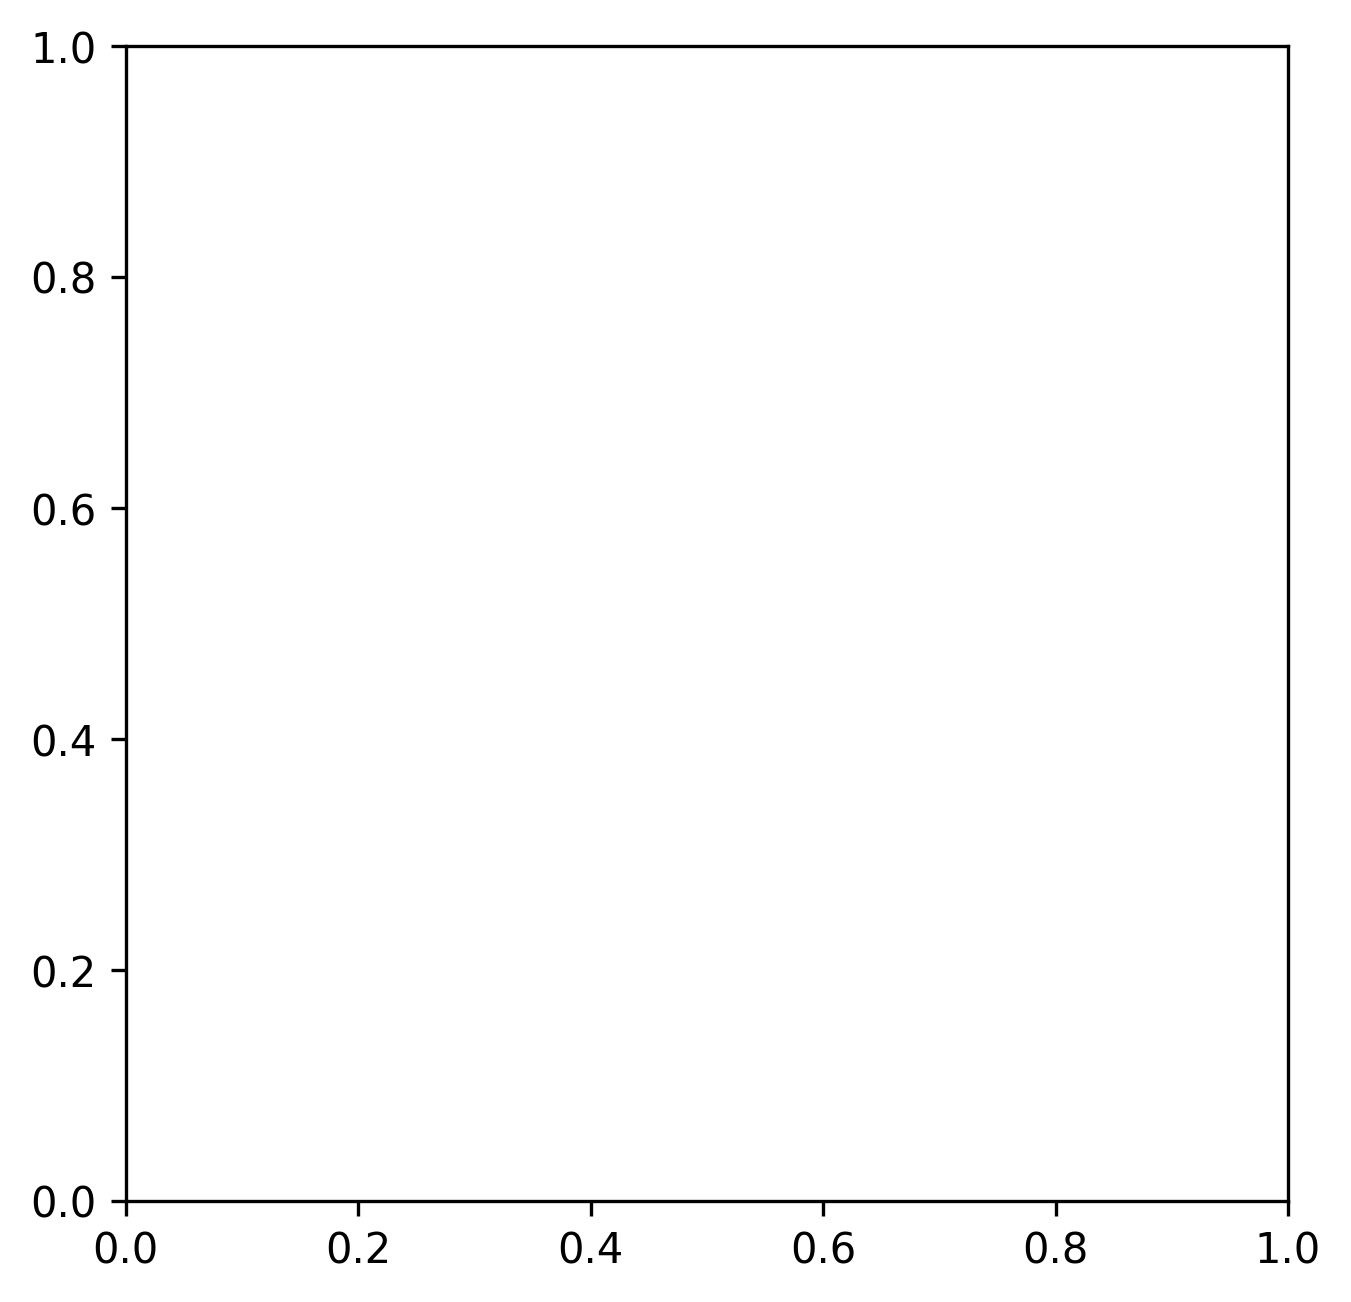

In [20]:
fig, ax = plt.subplots(figsize=(5,5), dpi=300)
ax.plot(np.cumsum(embedding.explained_variance_ratio_), lw=2, color="k")#, marker="o", markersize=5)
ax.set_xlabel("Principal Component Dimension")
ax.set_ylabel("Cumulative explained Variance Ratio")
# ax.set_title("PCA Explained Variance Ratio")

In [189]:
for ch, ch_dict in embedding_dict.items():
    print(ch, ch_dict["embedding"], ch_dict["values"].shape)

RAB5A fit (442, 442)


### Plot colorized pacmap/pca

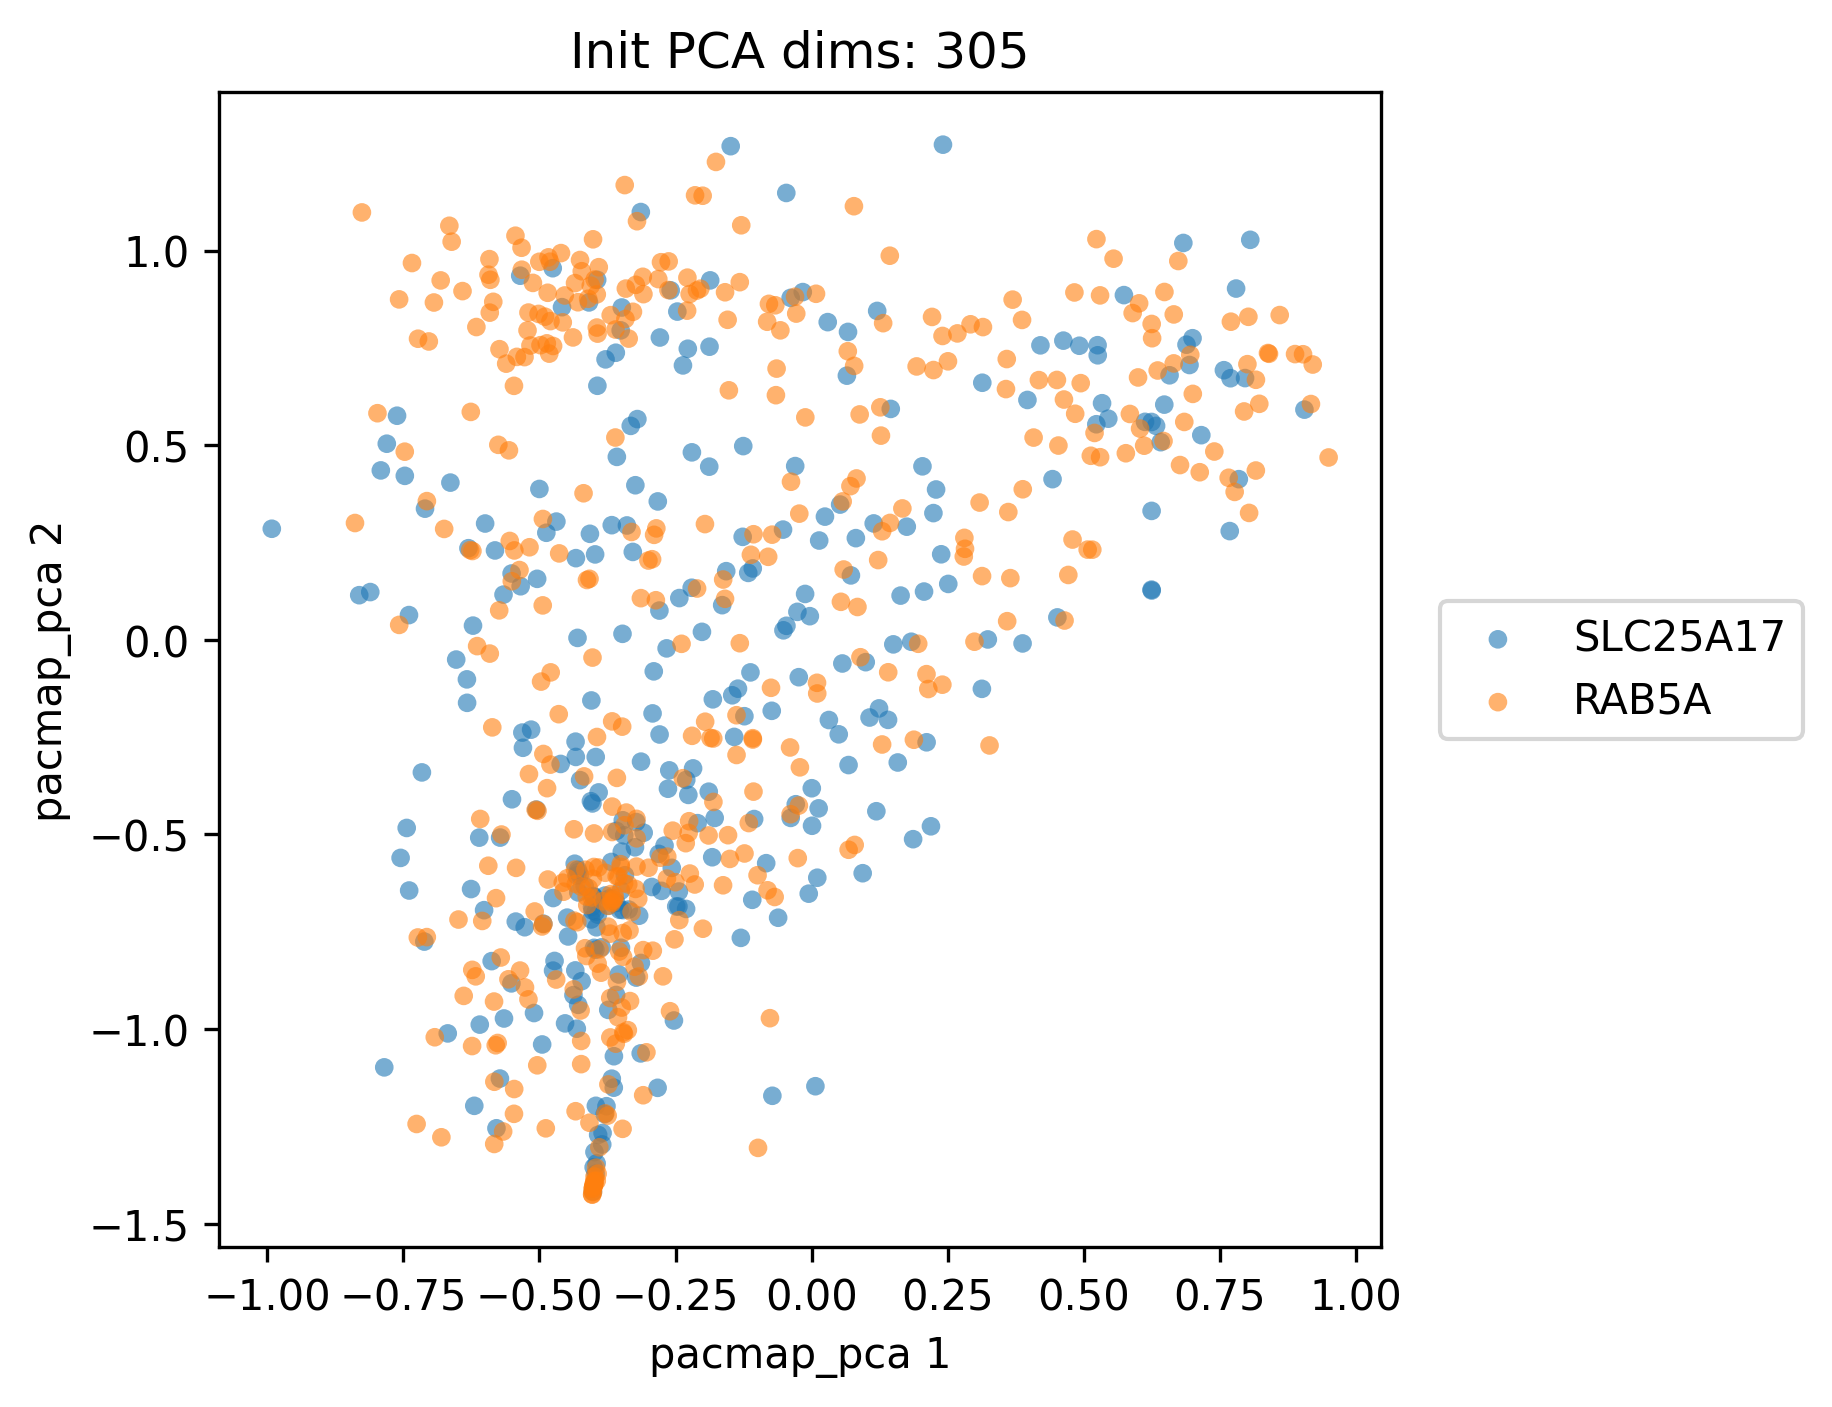

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
prev_ind = 0
for _col_ind, (ch, ch_dict) in enumerate(embedding_dict.items()):
    if "invert" in ch:
        continue
    embedding_type = ch_dict["embedding"]
    values = ch_dict["values"]
    ax.scatter(
        values[:, 0],
        values[:, 1],
        s=20,
        label=ch,
        alpha=0.6,
        marker="o" if embedding_type == "fit" else "x",
        # color=f"C{col_ind}",
        zorder=1 if embedding == "fit" else 2,
        edgecolors="none" if embedding_type == "fit" else None,
    )
if metric.lower() == "pacmap_pca":
    ax.set_title(f"Init PCA dims: {n_components_pca}")
ax.legend(bbox_to_anchor=(1.05, 0.5), loc="center left", borderaxespad=0.0)
# ax.set_xlim(-5, 15)
# ax.set_ylim(-5, 10)
ax.set_xlabel(f"{metric} 1")
ax.set_ylabel(f"{metric} 2")
plt.show()

In [ ]:
%matplotlib inline

In [ ]:
# zoom in to plot
ax.set_xlim(-5, 10)
ax.set_ylim(-5, 10)
plt.show()

## Latent walk along PCA embedding

In [133]:
embedding.n_components

305

In [191]:
ch_name = "RAB5A"

In [192]:
input_data = embedding_dict[ch_name]["values"]
print(input_data.shape)

(442, 442)


In [193]:
min(input_data[:, 1]), max(input_data[:, 1])

(-31.870969202084456, 53.895498917333605)

Histogram of pca values

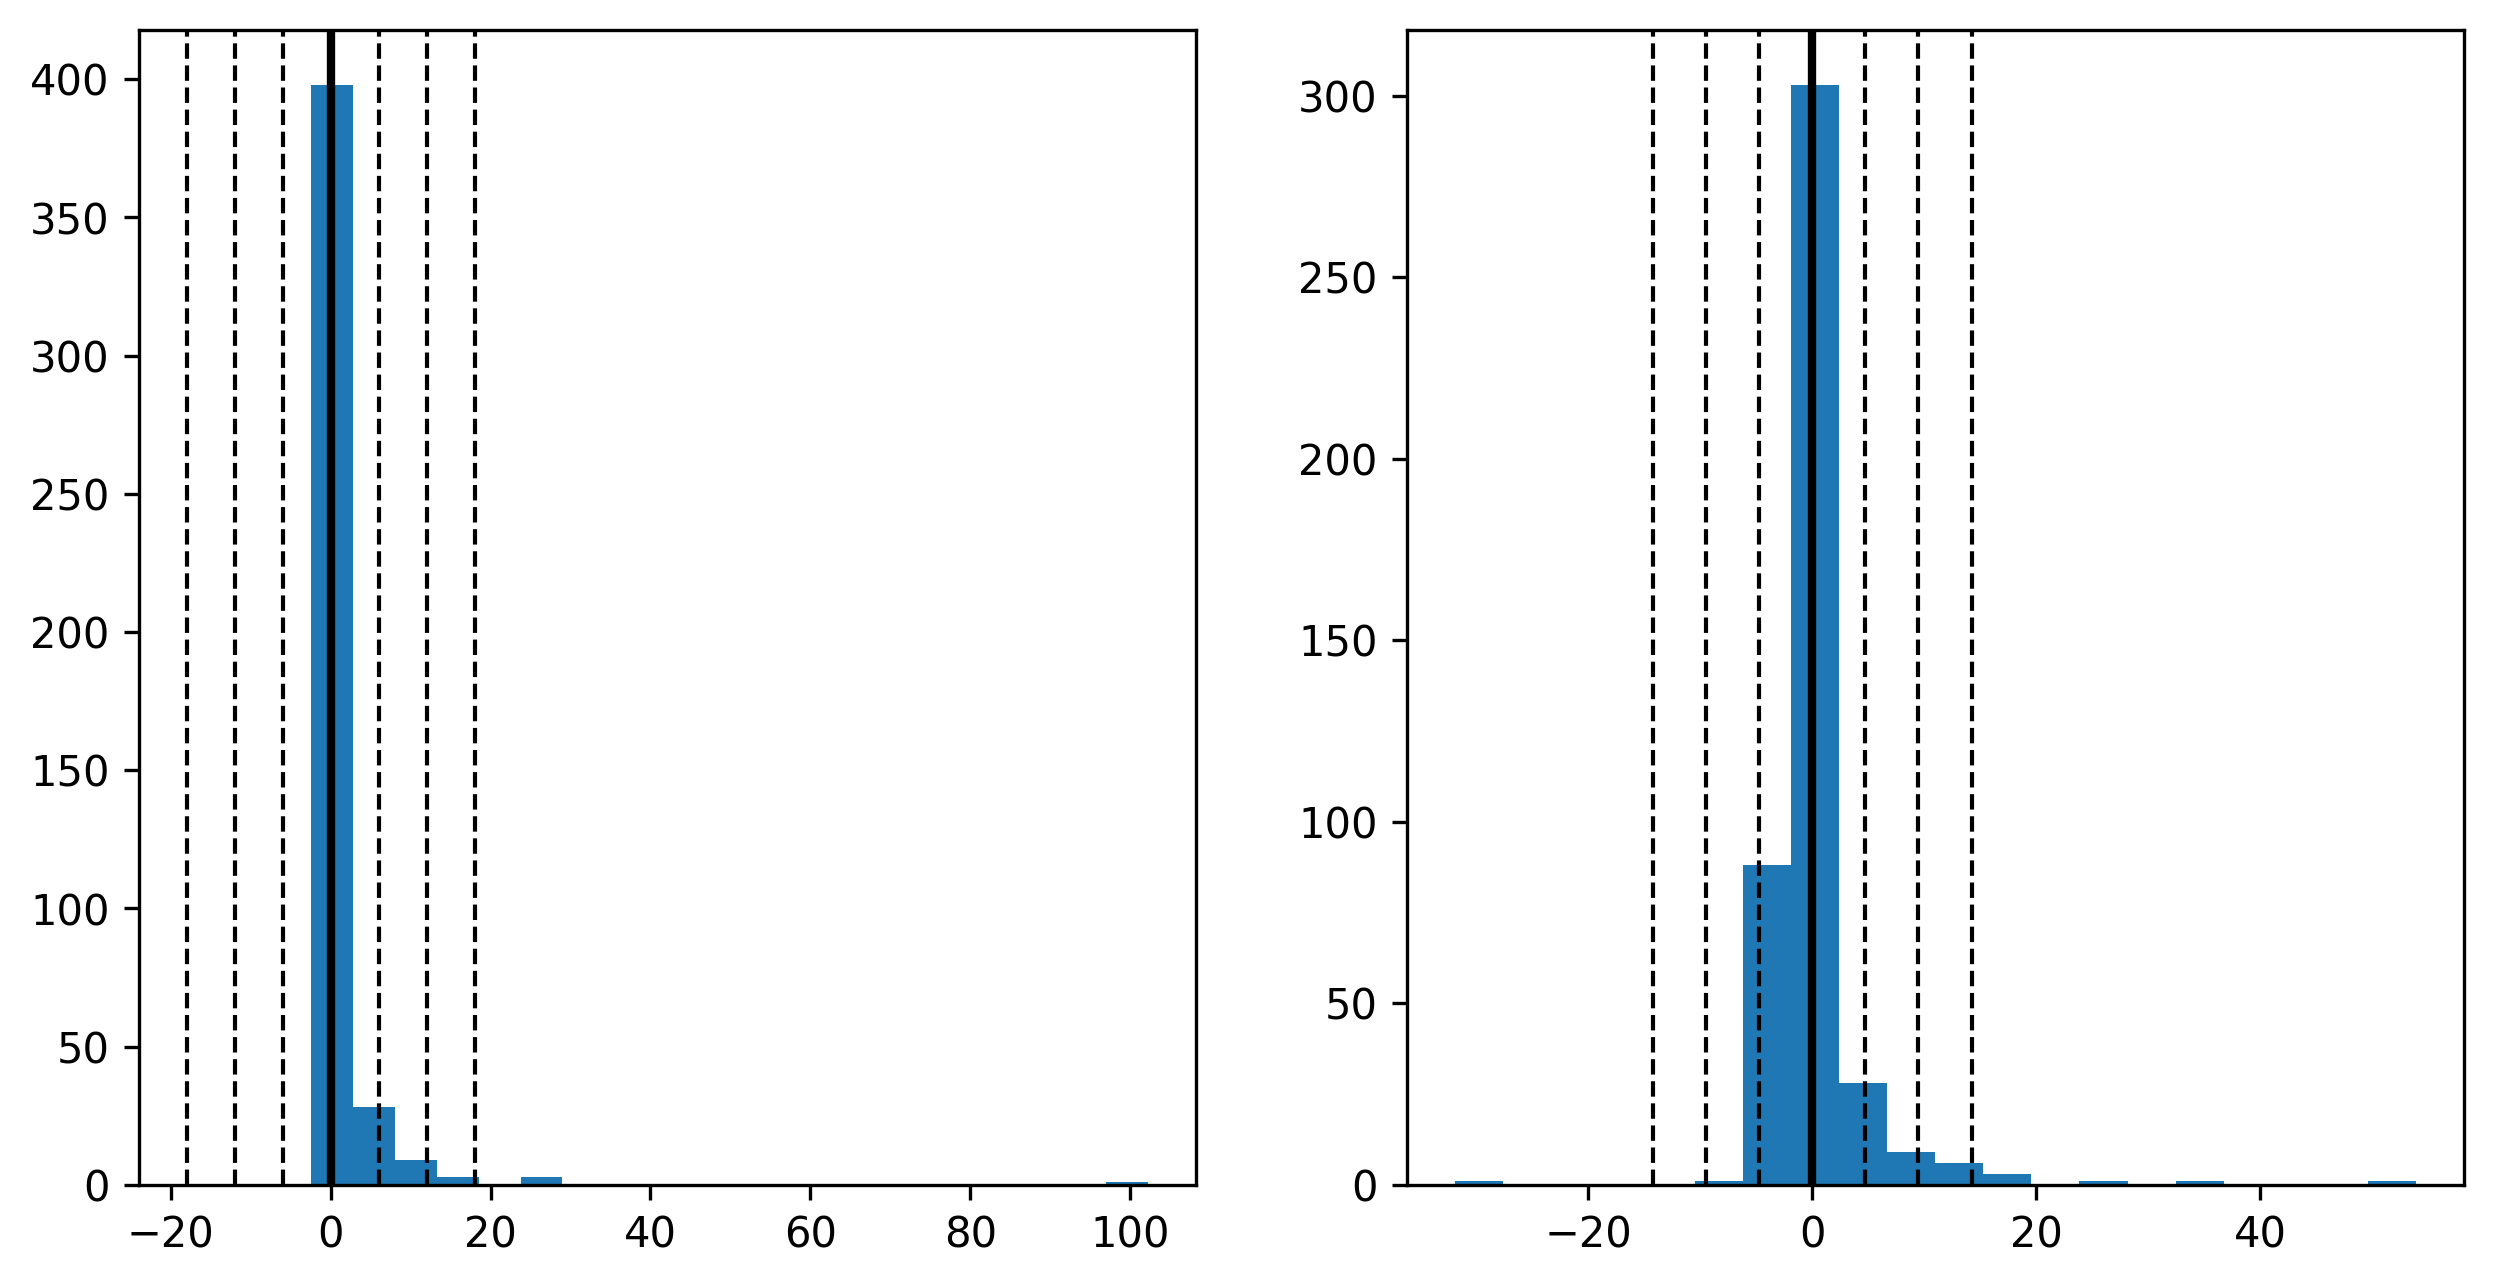

In [194]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=300)
for walk_dim in (0, 1):
    ax[walk_dim].hist(input_data[:, walk_dim], bins=20)
    ax[walk_dim].axvline(np.mean(input_data[:, walk_dim]), color="k", lw=2)
    for val in (1, 2, 3):
        ax[walk_dim].axvline(np.mean(input_data[:, walk_dim]) + val * np.std(input_data[:, walk_dim]), color="k", lw=1, ls="--")
        ax[walk_dim].axvline(np.mean(input_data[:, walk_dim]) - val * np.std(input_data[:, walk_dim]), color="k", lw=1, ls="--")
    
plt.show()

Get latent walk points

In [195]:
walk_dim = 1

In [196]:
# get up to 2 stds away from mean
num_std = 2
walk_pts = np.zeros((num_std * 2 + 1, input_data.shape[1]))
avg_dim_val = np.mean(input_data[:, walk_dim])
std_dim_val = np.std(input_data[:, walk_dim])
walk_pts[:, walk_dim] = avg_dim_val + np.arange(-num_std, num_std + 1) * std_dim_val
print(walk_pts.shape)

(5, 442)


In [197]:
num_pts = 5
walk_pts = np.zeros((num_pts, input_data.shape[1]))
sort_inds = np.argsort(input_data[:, walk_dim])
walk_inds = np.rint(np.linspace(0, len(sort_inds) - 1, num_pts)).astype(int)
walk_pts = input_data[sort_inds[walk_inds]]
print(walk_pts.shape)


(5, 442)


In [198]:
pilr_inds = sort_inds[walk_inds]
print(pilr_inds)

[385 161  25 433 358]


In [199]:
np.min(input_data[:, walk_dim]), np.max(input_data[:, walk_dim])

(-31.870969202084456, 53.895498917333605)

In [200]:
walk_pts[:, walk_dim]

array([-31.8709692 ,  -1.79267715,  -1.18559937,   0.14121254,
        53.89549892])

In [158]:
generated_pts = []
for walk_pt in walk_pts:
    generated_pt = embedding.inverse_transform(walk_pt)
    generated_pts.append(generated_pt)
generated_pts = np.array(generated_pts)
print(generated_pts.shape)


(5, 262208)


In [159]:
from cellpack_analysis.utilities.PILR_tools import (
    get_average_shape_mesh_objects,
    get_domain,
    get_parametrized_coords_for_avg_shape,
)
from cellpack_analysis.utilities.plotting_tools import save_PILR_image

get mesh_dict, domain and coords_param

In [160]:
mesh_path = Path(__file__).parents[2] / "data/average_shape_meshes"
mesh_dict = get_average_shape_mesh_objects(mesh_path)
domain = get_domain(mesh_dict)
coords_param = get_parametrized_coords_for_avg_shape(domain)

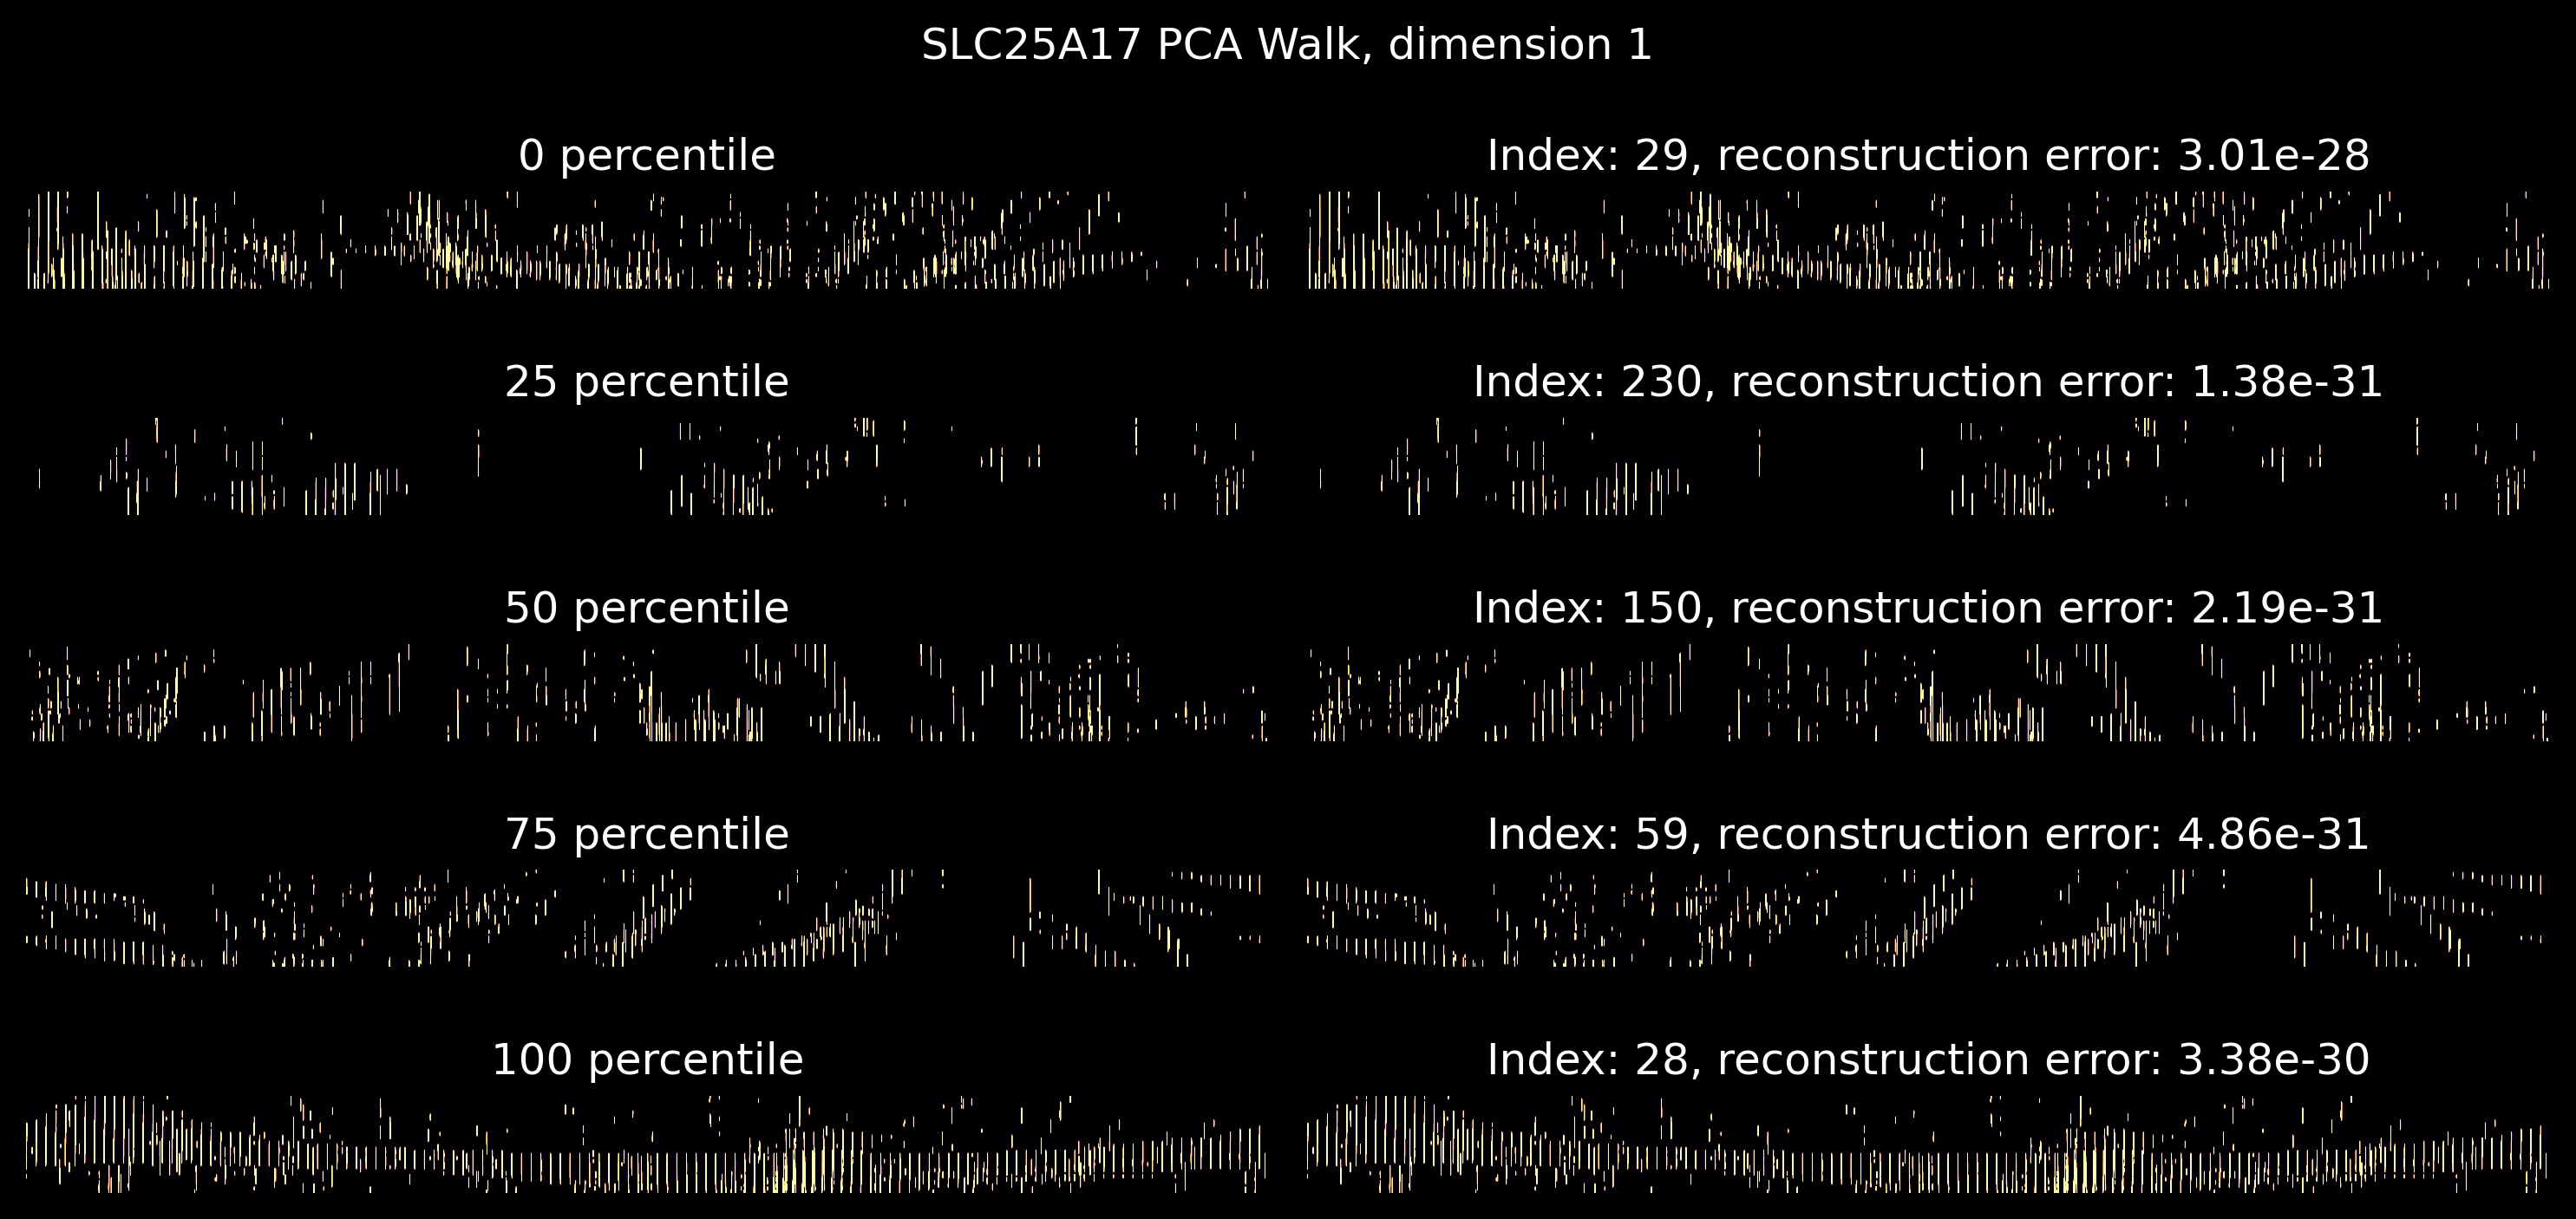

In [161]:
fig, axs = plt.subplots(generated_pts.shape[0], 2, figsize=(generated_pts.shape[0] * 2, 5), dpi=300)
pilr_list = []
for ct, generated_pt in enumerate(generated_pts):
    # plot the pilrs
    ax1 = axs[ct][0]
    ax2 = axs[ct][1]
    pilr = generated_pt.reshape(32, -1)
    actual_pilr = individual_PILR_dict[ch_name][pilr_inds[ct]].reshape(32, -1)
    reconstruction_error = np.mean((pilr - actual_pilr) ** 2)
    _, ax1 = save_PILR_image(pilr, ax=ax1, save_dir=None, aspect=20, vmax=0.05, vmin=0)
    _, ax2 = save_PILR_image(actual_pilr, ax=ax2, save_dir=None, aspect=20, vmax=0.05, vmin=0)
    # ax.set_title(f"{ct - len(generated_pts)//2} SD", c="w")
    ax1.set_title(f"{ct / (len(generated_pts) - 1) * 100:.3g} percentile", c="w")
    ax2.set_title(f"Index: {pilr_inds[ct]}, reconstruction error: {reconstruction_error:0.3g}", c="w")

    padded_pilr = np.zeros((pilr.shape[0] * 2 + 1, pilr.shape[1]))
    padded_pilr[actual_pilr.shape[0] // 2 : actual_pilr.shape[0] // 2 + actual_pilr.shape[0], :] = actual_pilr
    pilr_list.append(padded_pilr)

fig.suptitle(f"{ch_name} PCA Walk, dimension {walk_dim}", c="w")
plt.tight_layout()
plt.show(fig)

get reconstructions

In [162]:
from cellpack_analysis.utilities.PILR_tools import morph_PILRs_into_average_shape
from cellpack_analysis.utilities.plotting_tools import (
    plot_and_save_center_slice,
)

In [163]:
morphed = morph_PILRs_into_average_shape(
    pilr_list=pilr_list,
    domain=domain,
    coords_param=coords_param,
    mesh_dict=mesh_dict,
)

In [164]:
dim_to_axis_map = {
    0: "XZ",
    1: "XY",
    2: "YZ",
}

In [165]:
dim_to_axis_map[0]

'XZ'

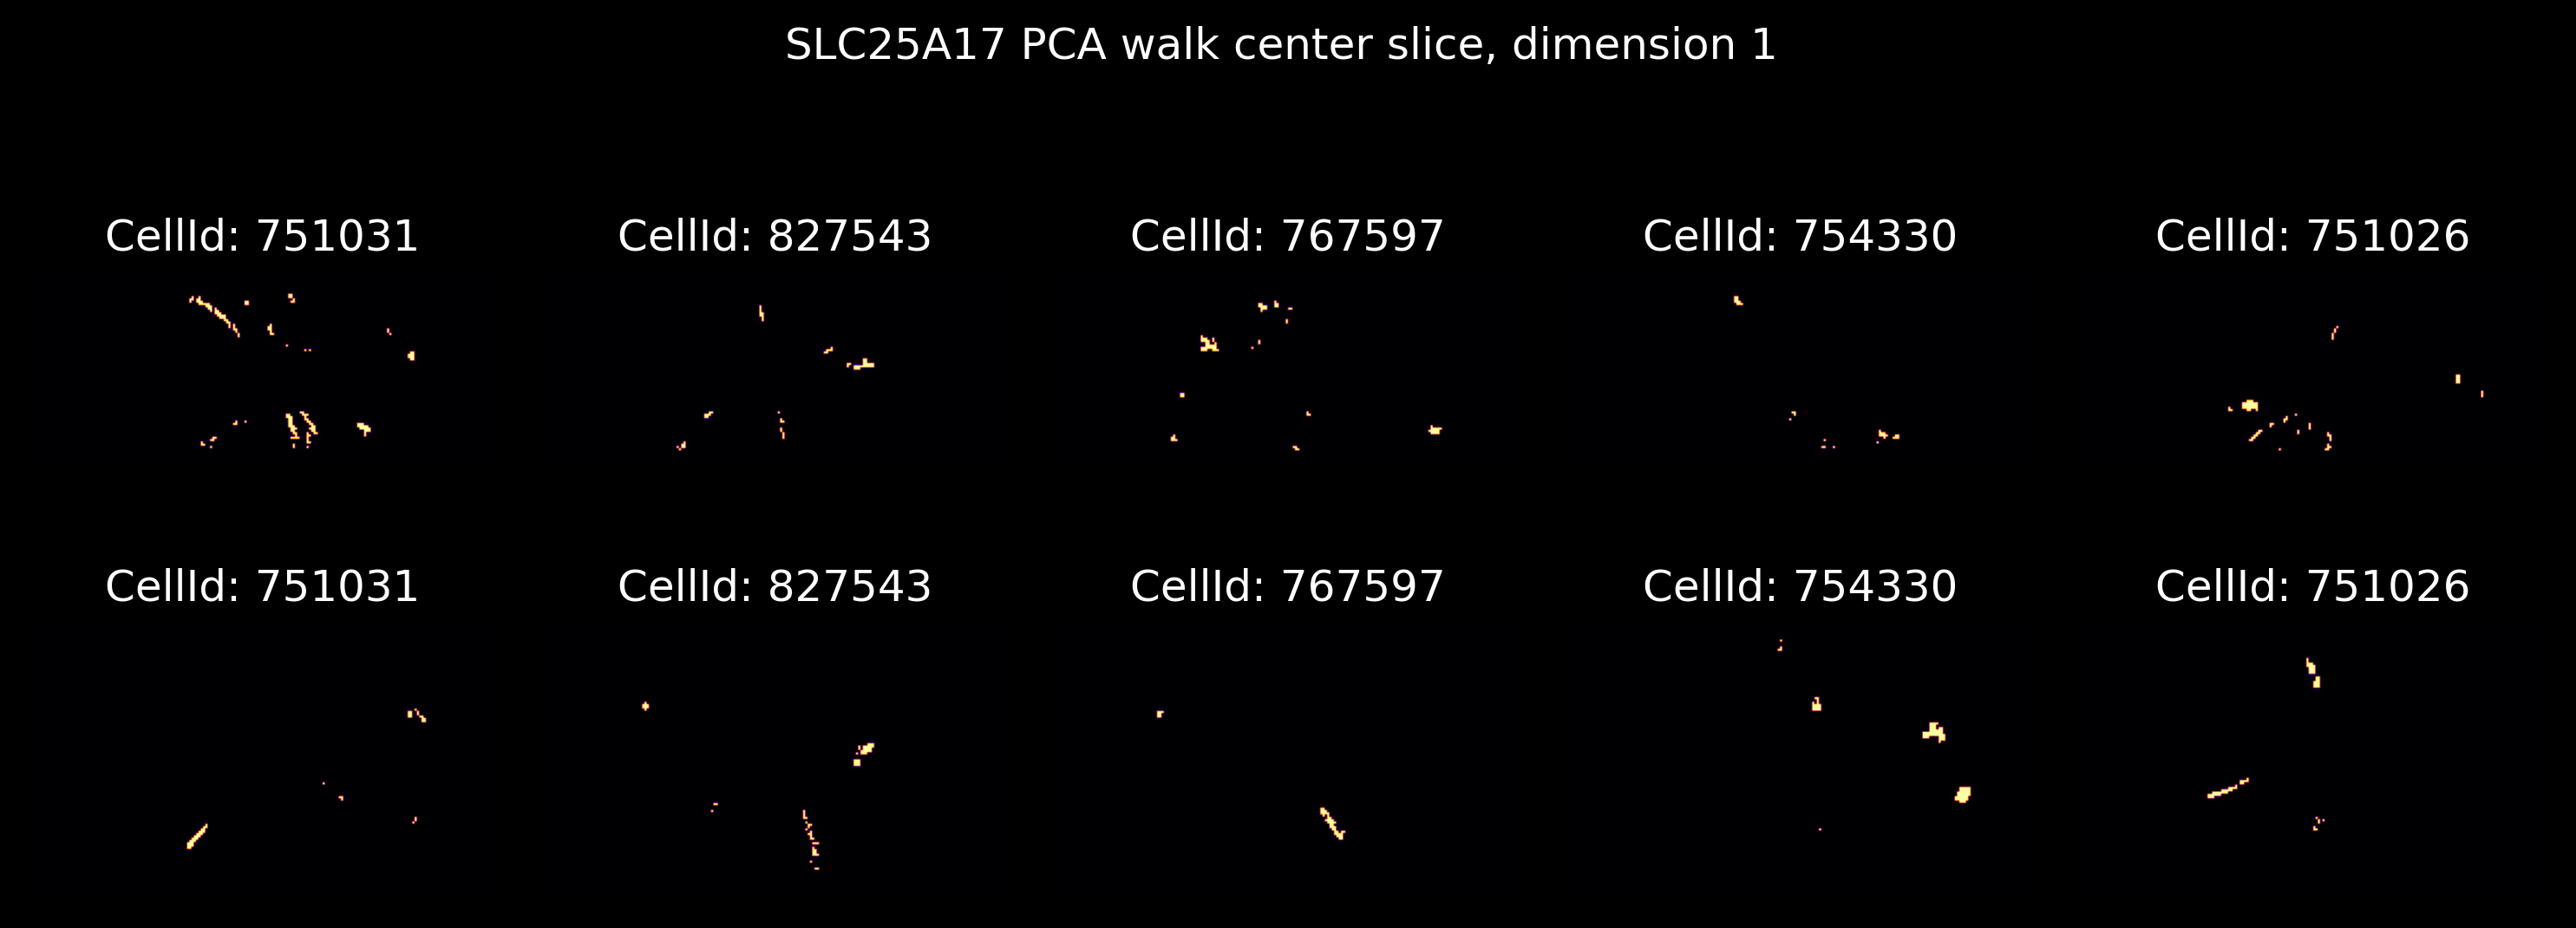

In [166]:
fig, axs = plt.subplots(2, len(morphed), figsize=(len(morphed) * 2, 4), dpi=300)
for ct, morph in enumerate(morphed):
    for dim in range(2):
        fig, axs[dim][ct] = plot_and_save_center_slice(
            morph,
            structure=ch_name,
            dim=dim,
            ax=axs[dim][ct],
            title=f"CellId: {cell_id_dict[ch_name][pilr_inds[ct]]}",
            ylabel=f"{dim_to_axis_map[dim]}" if ct==0 else None,
            showfig=False,
        )

fig.suptitle(f"{ch_name} PCA walk center slice, dimension {walk_dim} ", c="w")
plt.tight_layout()
plt.show()


Look at outliers

In [202]:
ch_name = "RAB5A"

In [207]:
walk_dim = 1

In [208]:
cell_id_list = cell_id_dict[ch_name]

In [209]:
input_data.shape

(442, 442)

get outliers along dimension

In [210]:
sort_inds = np.argsort(input_data[:, walk_dim])
walk_pts = input_data[sort_inds[-3:]]
outlier_cell_id = [cell_id_list[ind] for ind in sort_inds[-2:]]
print(walk_pts[:, walk_dim], outlier_cell_id)

[25.76350165 33.98974694 53.89549892] [933442, 932189]


get outlier based on distance

In [182]:
pt = np.array([10, 20])
distances = np.linalg.norm(input_data[:, :2] - pt, axis=1)
min_ind = np.argmin(distances)
outlier_cell_id = cell_id_list[min_ind]
print(outlier_cell_id)


760286
